In [1]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model, preprocessing
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
def read_transaction_by_Q(q):
    """
    Read transaction data from a CSV file and return a sorted DataFrame.
    Parameters:
    - q (str): The name of the CSV file (without the extension) containing transaction data.

    Returns:
    - pd.DataFrame: A DataFrame containing transaction data sorted by "postDate".
    """
    # Read CSV file
    transactions = pd.read_csv(q + '.csv')

    # Sort the DataFrame by "postDate"
    transactions = transactions.sort_values(by="postDate")

    # Reset the index
    transactions = transactions.reset_index(drop=True)

    return transactions


In [13]:
def process_transactions(transactions):
    """
    Process transaction data and add a 'total_balance' column.

    Parameters:
    - transactions (pd.DataFrame): DataFrame containing transaction data.

    Returns:
    - pd.DataFrame: Processed DataFrame with a new 'total_balance' column and 'postDate' as the index.
      Returns None if there is an error in converting 'postDate' to datetime format.
    """
    # Get initial balance with the first 'balance' value
    initial_balance = transactions.at[0, 'balance']

    # Set the 'total_balance' of the first row to be the initial balance
    transactions.at[0, 'total_balance'] = initial_balance

    # Iterate through each row in transactions starting from the second row (index 1)
    for index, row in transactions.iterrows():
        if index == 0:
            continue  # Skip the first row since we already set the initial balance
        amount = row['amount']

        # calculate the running balance across all accounts
        initial_balance += amount

        # update the 'total_balance' column
        transactions.at[index, 'total_balance'] = initial_balance

    # Insert the 'total_balance' column at the specified position
    transactions.insert(7, 'total_balance', transactions.pop('total_balance'))

    # Drop unnecessary columns
    transactions = transactions[['total_balance', 'postDate']]

    try:
        # Convert 'postDate' column to datetime format
        transactions['postDate'] = pd.to_datetime(transactions['postDate'])

        # Set the 'postDate' column as the index
        return transactions
    except ValueError:
        print("Error: 'postDate' column could not be converted to datetime format.")
        return None


In [15]:
from scipy import stats
import pandas as pd

def group_data(transactions, option='mean'):
    """
    Group time series data based on the specified option and resample to daily frequency.

    Parameters:
    - transactions (pd.DataFrame): DataFrame containing time series data with 'total_balance'.
    - option (str, optional): Aggregation option for grouping ('mean', 'min', 'max', or 'sum').
                              Default is 'mean'.

    Returns:
    - pd.DataFrame: Grouped and resampled DataFrame with 'total_balance' based on the chosen option.
    """
    if option == 'mean':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'mean'}).reset_index()
    elif option == 'min':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'min'}).reset_index()
    elif option == 'max':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'max'}).reset_index()
    else:
        transactions = transactions.groupby('postDate').agg({'total_balance': 'sum'}).reset_index()

    # Reset the index to have 'postDate' as a regular column again
    transactions.set_index('postDate', inplace=False)
    transactions['postDate'] = pd.to_datetime(transactions['postDate'])
    transactions.set_index('postDate', inplace=True)

    # Then, resample the DataFrame with daily frequency and forward-fill missing values
    transactions = transactions.resample('D').ffill()

    # Apply forward filling per each day
    return transactions


C:\Users\rayed\AppData\Local\Temp\ipykernel_25280\3950685597.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['postDate'] = pd.to_datetime(transactions['postDate'])


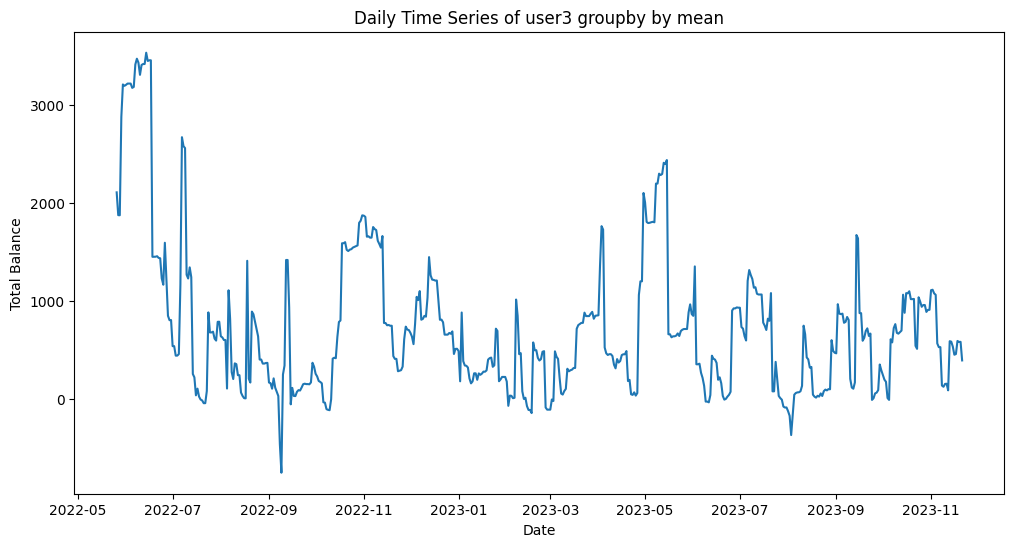

,total_balance
postDate,
2022-05-26 00:00:00+00:00,2106.09
2022-05-27 00:00:00+00:00,1874.09
2022-05-28 00:00:00+00:00,1873.09
2022-05-29 00:00:00+00:00,2873.09
2022-05-30 00:00:00+00:00,3204.09
...,...
2023-11-17 00:00:00+00:00,460.84
2023-11-18 00:00:00+00:00,593.64
2023-11-19 00:00:00+00:00,583.64


In [16]:
# Read Q data
def read_process_Q_data(Q, plot, option):
    """
    Read, process, and optionally plot time series data for a specific Q.

    Parameters:
    - Q (str): Name of the Q for which data is to be processed.
    - plot (bool): Whether to plot the time series data or not.
    - option (str): Aggregation option for grouping ('mean', 'min', 'max', or 'sum').

    Returns:
    - pd.DataFrame or None: Processed and optionally plotted time series data for the specified Q.
                            Returns None if an error occurs during data processing.
    """
    Q_data = read_transaction_by_Q(Q)
    Q_data_processed = process_transactions(Q_data)
    if Q_data_processed is not None:
        Q_data_grouped = group_data(Q_data_processed, option=option)
        if plot:
            plot_transactions(Q_data_grouped, f'Daily Time Series of {Q} groupby by {option}')
        return Q_data_grouped
    else:
        return None

data = read_process_Q_data('user3', True, 'mean')
data


# Random Forest

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

In [21]:
def feature_creation(data):
    """
    Create additional time-related features based on the index of the input DataFrame.

    Parameters:
    - data (pd.DataFrame): DataFrame containing time series data with a DateTimeIndex.

    Returns:
    - pd.DataFrame: DataFrame with added time-related features.
    """
    data = data.copy()

    # Extracting time-related features
    data['week'] = data.index.day_of_week
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['dayofweek'] = data.index.day_of_week

    return data


In [ ]:
# Create features for Random Forest model
# Parameters:
# - data (pd.DataFrame): DataFrame containing time series data with a DateTimeIndex.
#
# Returns:
# - pd.DataFrame: DataFrame with added time-related features.

# Extract features and target variable for Random Forest model
# - FEATURES (list): List of feature names.
# - TARGET (str): Name of the target variable.
#
# Returns:
# - pd.DataFrame: Features (X) and target variable (y) DataFrames.


RF_Data = feature_creation(data)
# RF_Data = lag_creation(RF_Data)
RF_Data.dropna()
FEATURES = list((RF_Data.drop('total_balance', axis=1)).columns)
TARGETS = 'total_balance'

X = RF_Data[FEATURES]
y = RF_Data[TARGETS]
print(X)

In [26]:
model = RandomForestRegressor()

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
model = RandomForestRegressor()

param_grid = {
    # 'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1, verbose=10, scoring='neg_mean_squared_error')
results = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START max_depth=None, min_samples_leaf=1, min_samples_split=2....
[CV 1/5; 1/27] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-2388454.398 total time=   0.4s
[CV 2/5; 1/27] START max_depth=None, min_samples_leaf=1, min_samples_split=2....
[CV 2/5; 1/27] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-520319.739 total time=   0.2s
[CV 3/5; 1/27] START max_depth=None, min_samples_leaf=1, min_samples_split=2....
[CV 3/5; 1/27] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-109668.477 total time=   0.2s
[CV 4/5; 1/27] START max_depth=None, min_samples_leaf=1, min_samples_split=2....
[CV 4/5; 1/27] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-1142712.529 total time=   0.3s
[CV 5/5; 1/27] START max_depth=None, min_samples_leaf=1, min_samples_split=2....
[CV 5/5; 1/27] END max_depth=None, min_samples_leaf=1, min_samples_split=2;

In [29]:
best_params = results.best_params_
best_params

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}

Random Forest
Mean Squared Error: 332005.2417299503
R-squared: -1.222291968444884
Root Mean Squared Error: 576.1989601951311


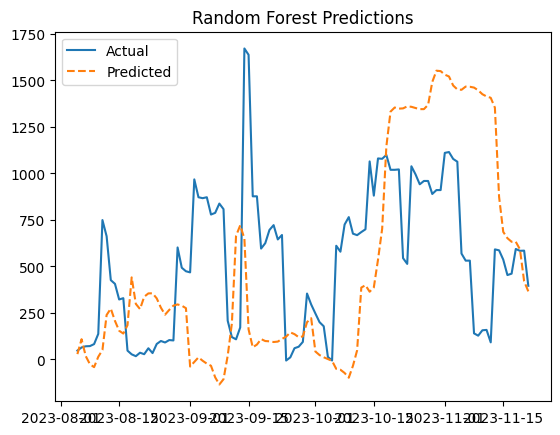

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=best_params['max_depth']
)

# Uncomment the line below if you are using a specific value for 'n_estimators'
# rf_model = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     min_samples_split=best_params['min_samples_split'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     max_depth=best_params['max_depth']
# )

# Fit the Random Forest model to the training data
rf_model_fit = rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_model_prediction = rf_model_fit.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest")
mse = mean_squared_error(y_test, rf_model_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_model_prediction)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)

# Plot the actual vs predicted values
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, rf_model_prediction, label='Predicted', linestyle='dashed')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
residuals = y_test - rf_model_prediction

In [33]:
lr_model = LinearRegression()
lr_model_fit = lr_model.fit(X_test, residuals)
lr_model_prediction = lr_model_fit.predict(X_test)

In [34]:
# Combine the predictions from both models
rf_lr_prediction = rf_model_prediction + lr_model_prediction

In [40]:
from xgboost import XGBRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=best_params['max_depth']
)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train a Gradient Boosting model (XGBoost example)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Combine predictions (simple averaging)
combined_predictions = (rf_predictions + xgb_predictions) / 2

# Evaluate the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_r2 = r2_score(y_test, combined_predictions)

print("Combined Model")
print("Mean Squared Error:", combined_mse)
print("R-squared:", combined_r2)
print("Root Mean Squared Error:", combined_rmse)
#Mean Squared Error: 255257.74317266452


Combined Model
Mean Squared Error: 344903.2856713792
R-squared: -1.3086256037523682
Root Mean Squared Error: 587.2846717490413


In [45]:
from sklearn.neural_network import MLPRegressor

# Instantiate and train MLPRegressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Make predictions using the trained model
mlp_predictions = mlp_model.predict(X_test)

# Evaluate the MLPRegressor model
mlp_mse = mean_squared_error(y_test, mlp_predictions)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(y_test, mlp_predictions)

print("MLPRegressor Model")
print("Mean Squared Error:", mlp_mse)
print("R-squared:", mlp_r2)
print("Root Mean Squared Error:", mlp_rmse)


MLPRegressor Model
Mean Squared Error: 253993.6308349889
R-squared: -0.7001177538632568
Root Mean Squared Error: 503.977807879463


Random Forest and Linear Regression Ensemble Model
Mean Squared Error: 255257.74317266452
R-squared: -0.7085791464623337
Root Mean Squared Error: 505.23038623252313

Random Forest Regression
Mean Squared Error: 332005.2417299503
R-squared: -1.222291968444884
Root Mean Squared Error: 576.1989601951311

Linear Regression
Mean Squared Error: 542296.4741425661
R-squared: -2.6298857594039218
Root Mean Squared Error: 736.4078178173871

MLP Regressor
Mean Squared Error: 253993.6308349889
R-squared: -0.7001177538632568
Root Mean Squared Error: 503.977807879463


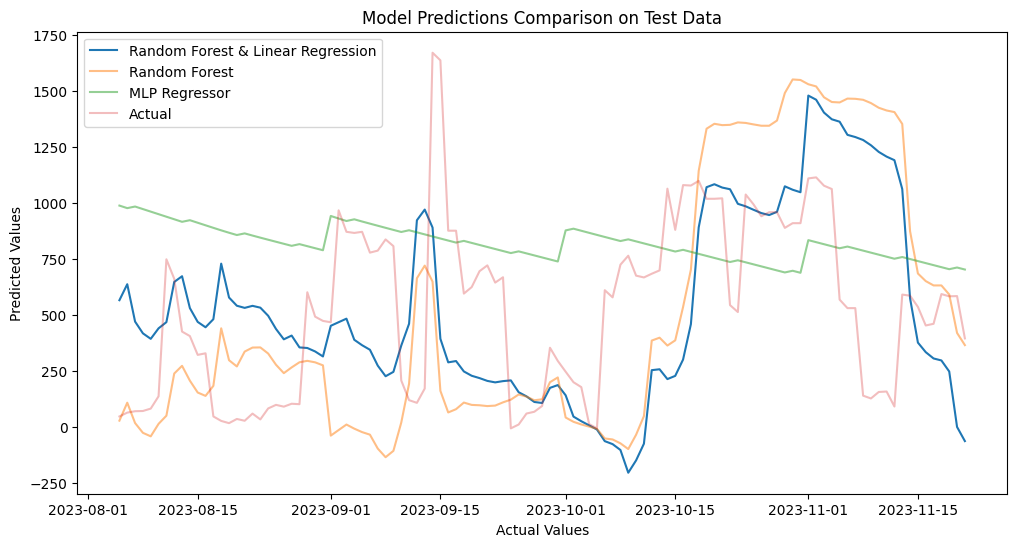

In [47]:
# Plotting the actual vs Ensemble predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, rf_lr_prediction, label='Random Forest & Linear Regression', alpha=1)
plt.plot(y_test.index, rf_model_prediction, label='Random Forest', alpha=0.5)
plt.plot(y_test.index, mlp_predictions, label='MLP Regressor', alpha=0.5)
plt.plot(y_test.index, y_test, label='Actual', alpha=0.3)

# Evaluate Random Forest and Linear Regression Ensemble Model
print("Random Forest and Linear Regression Ensemble Model")
mse = mean_squared_error(y_test, rf_lr_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_lr_prediction)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)

print()

# Evaluate Random Forest Regression
print("Random Forest Regression")
mse = mean_squared_error(y_test, rf_model_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_model_prediction)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)

print()

# Evaluate Linear Regression
print("Linear Regression")
mse = mean_squared_error(y_test, lr_model_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lr_model_prediction)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)

print()

# Evaluate MLPRegressor
print("MLP Regressor")
mse = mean_squared_error(y_test, mlp_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, mlp_predictions)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Model Predictions Comparison on Test Data')
plt.show()


In [36]:
from datetime import timedelta

def forecast(days):
    """
    Generate a forecast for a specified number of future days.

    Parameters:
    - days (int): Number of days to forecast into the future.

    Returns:
    - pd.DataFrame: DataFrame containing forecasted data with additional features.
    """
    data = RF_Data.copy()

    # Get the current maximum date in the data
    current = data.index.max()

    # Calculate the future date range based on the specified number of days
    future = current + timedelta(days=days)
    future_data = pd.date_range(current, future, freq='1D')
    future_data = pd.DataFrame(index=future_data)

    # Include a new column for predictions on both dataframes
    future_data['prediction'] = True
    data['prediction'] = False

    # Concatenate the current data with the future data
    RF_Data_Predict = pd.concat([data, future_data])

    # Create additional time-related features for the combined data
    RF_Data_Predict = feature_creation(RF_Data_Predict)

    # Extract only the rows with prediction flag set to True
    predictions_features = RF_Data_Predict.query('prediction').copy()

    return predictions_features

<Figure size 1200x600 with 0 Axes>

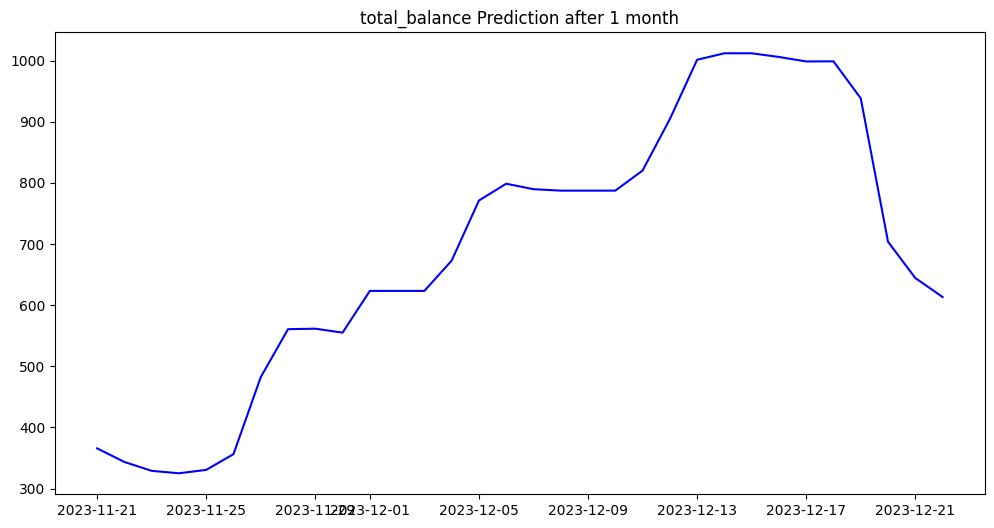

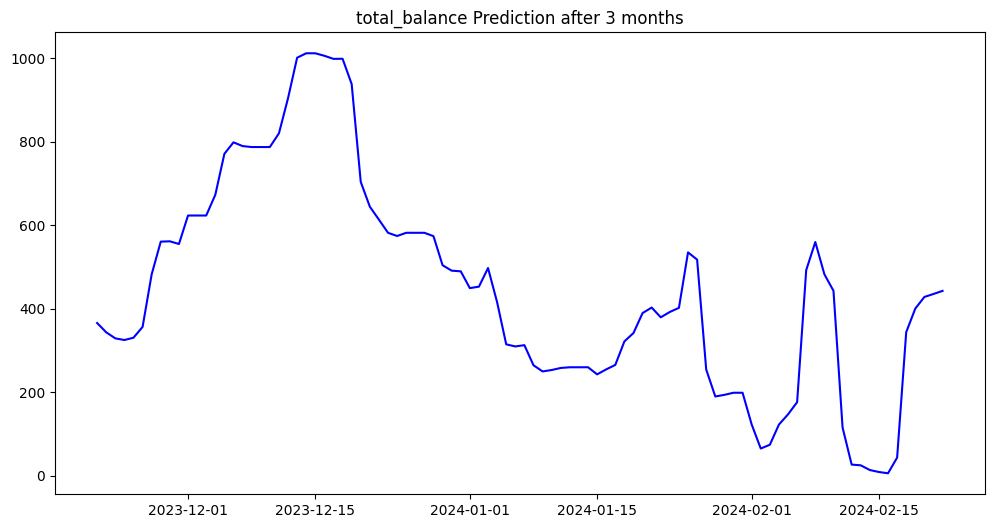

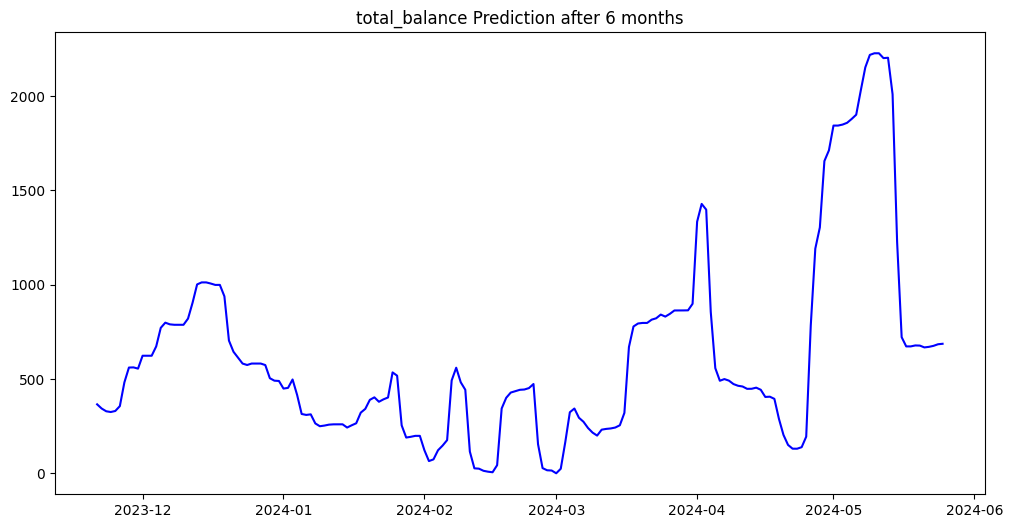

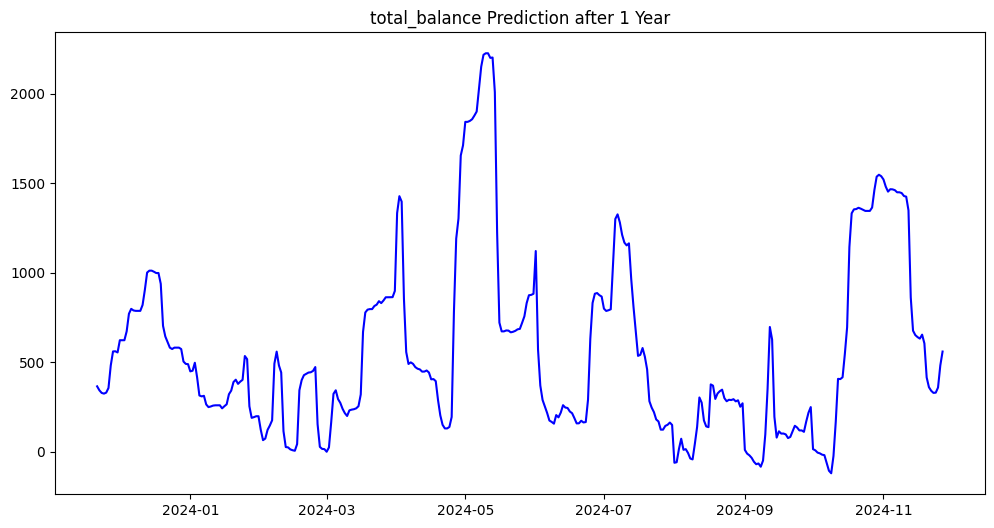

In [37]:
plt.figure(figsize=(12, 6))

# Generate future predictions for different time horizons
month = forecast(31)
three_month = forecast(31*3)
six_month = forecast(31*6)
year = forecast(31*12)

# Apply predicted models for each time horizon
month_rf_future_prediction = rf_model_fit.predict(month[FEATURES])
month_lr_future_prediction = lr_model_fit.predict(month[FEATURES])

three_month_rf_future_prediction = rf_model_fit.predict(three_month[FEATURES])
three_month_lr_future_prediction = lr_model_fit.predict(three_month[FEATURES])

six_month_rf_future_prediction = rf_model_fit.predict(six_month[FEATURES])
six_month_lr_future_prediction = lr_model_fit.predict(six_month[FEATURES])

year_rf_future_prediction = rf_model_fit.predict(year[FEATURES])
year_lr_future_prediction = lr_model_fit.predict(year[FEATURES])

# Ensemble predictions for each time horizon
month_ensemble_future_predictions = month_rf_future_prediction + month_lr_future_prediction
three_month_ensemble_future_predictions = three_month_rf_future_prediction + three_month_lr_future_prediction
six_month_ensemble_future_predictions = six_month_rf_future_prediction + six_month_lr_future_prediction
year_ensemble_future_predictions = year_rf_future_prediction + year_lr_future_prediction

# Plotting the future predictions after 1 month
plt.figure(figsize=(12, 6))
plt.plot(month.index, month_rf_future_prediction, label='Ensemble Predictions (Future)', color='blue', alpha=1)
plt.title('total_balance Prediction after 1 month')
plt.show()

# Plotting the future predictions after 3 months
plt.figure(figsize=(12, 6))
plt.plot(three_month.index, three_month_rf_future_prediction, label='Ensemble Predictions (Future)', color='blue', alpha=1)
plt.title('total_balance Prediction after 3 months')
plt.show()

# Plotting the future predictions after 6 months
plt.figure(figsize=(12, 6))
plt.plot(six_month.index, six_month_rf_future_prediction, label='Ensemble Predictions (Future)', color='blue', alpha=1)
plt.title('total_balance Prediction after 6 months')
plt.show()

# Plotting the future predictions after 1 year
plt.figure(figsize=(12, 6))
plt.plot(year.index, year_rf_future_prediction, label='Ensemble Predictions (Future)', color='blue', alpha=1)
plt.title('total_balance Prediction after 1 Year')
plt.show()


Final Output Data
* save each of the models into another file.
* make sure the have userX.csv read from csv
* add some comments on code